# LSTM Model for Predicting Sunspots

## Project Overview
This project focused on analyzing sunspot activity and designing, training, evaluating and predicting sunspot counts using LSTM, GRU, and Bidirectional LSTM models. Sunspots are studied because their activity has implications in solar radiation and can affect space and terrestrial communication.  

### Goals

Process and analyze historic sunspot dataset.

Develop and tune LSTM, GRU, and BiLSTM models.

Evaluate using RMSLE and RMSE.



In [28]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from keras_tuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping


#set the default aesthetic parameters to seaborns's default settings
sns.set()


# Data Processing

Below we load the sunspot data into a Pandas DataFrame and then display the basic stats with an initial snapshot of the data to better understand the dataset's structure and general properties.

In [29]:
# DATA PREPROCESSING

# Load the dataset
file_path = './sunspot_data.csv'
sunspot_df = pd.read_csv(file_path)

# Display basic stats about the dataset
print(sunspot_df.head())
print(sunspot_df.describe())

   Unnamed: 0  Year  Month  Day  Date In Fraction Of Year  Number of Sunspots  \
0           0  1818      1    1                  1818.001                  -1   
1           1  1818      1    2                  1818.004                  -1   
2           2  1818      1    3                  1818.007                  -1   
3           3  1818      1    4                  1818.010                  -1   
4           4  1818      1    5                  1818.012                  -1   

   Standard Deviation  Observations  Indicator  
0                -1.0             0          1  
1                -1.0             0          1  
2                -1.0             0          1  
3                -1.0             0          1  
4                -1.0             0          1  
         Unnamed: 0          Year         Month           Day  \
count  73718.000000  73718.000000  73718.000000  73718.000000   
mean   36858.500000   1918.416750      6.518896     15.729347   
std    21280.697909     

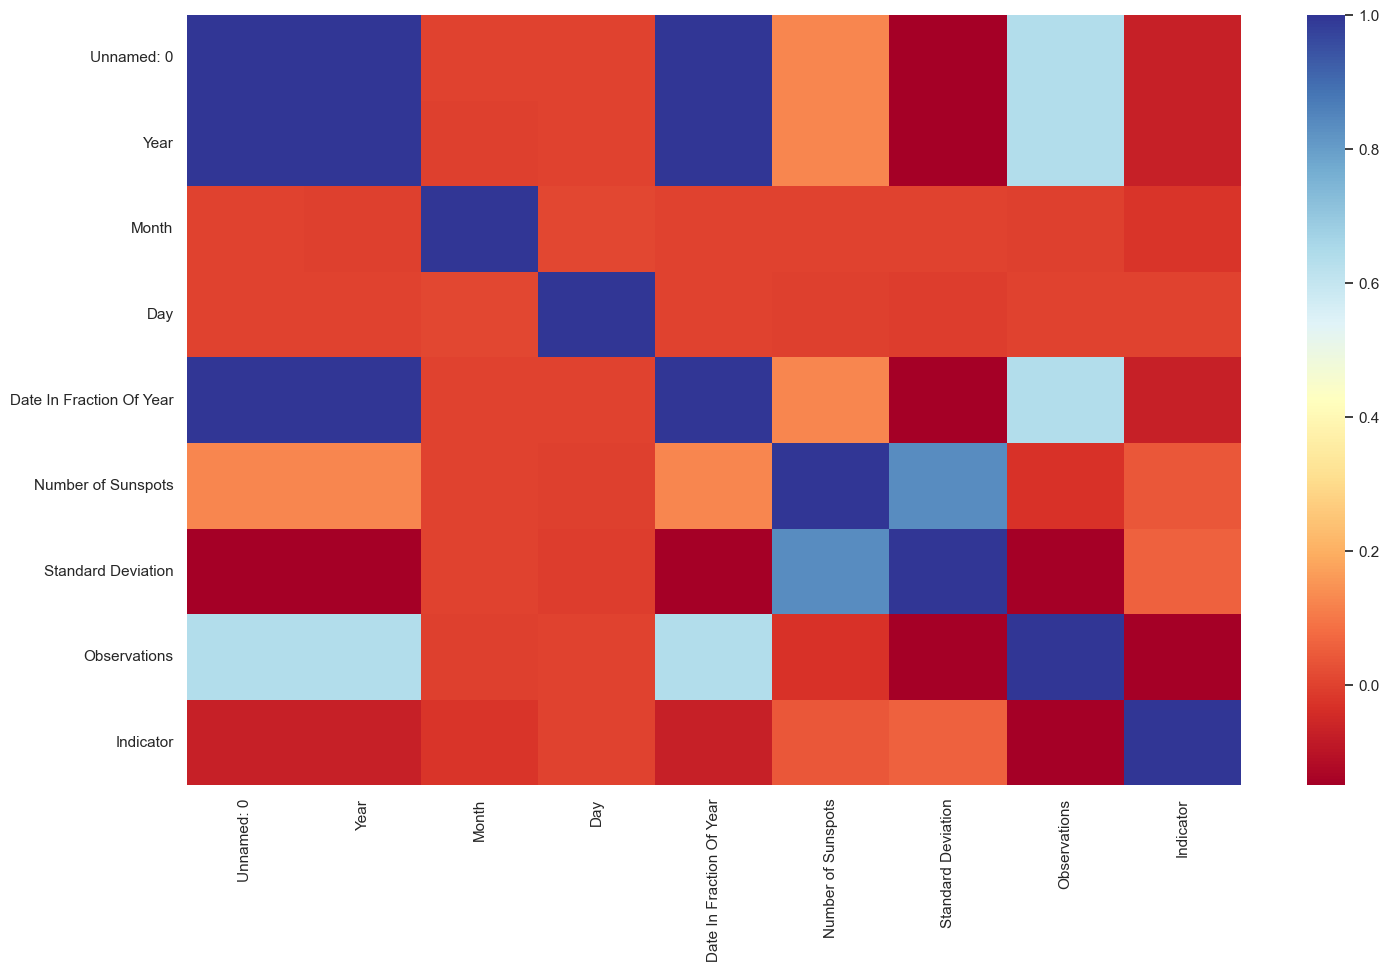

In [30]:
# Correlation heatmap
# we use a heatmap to visualize linear relationships between the data's features

plt.figure(figsize=(17, 10))
sns.heatmap(sunspot_df.corr(), cmap='RdYlBu')
plt.show()

### Heat-map interpretation

Dark blue areas on the heatmap have a strong positive correlation.  This means that when one feature increases, the other also increases.  

The red areas have a very limited to no correlation.  This is true for most of the data features.

Light blue areas have a moderately strong positive correlation.  

## Data Preparation.

Below we split the data into a train and test sets.  Data from prior to the year 2000 will be used to train the data, data from after the year 2000 will be used to test the data.  

From the results we see that the training data has 66474 observations, and the test data has 7244 observations.  This is about a 90:10 split for training data : test data.

In [31]:
# Split the dataset into training and testing sets
train_df = sunspot_df[sunspot_df['Year'] < 2000]
test_df = sunspot_df[sunspot_df['Year'] >= 2000]

sunspots_train = train_df['Number of Sunspots'].tolist()
sunspots_test = test_df['Number of Sunspots'].tolist()

print(f"Training set has {len(sunspots_train)} observations.")
print(f"Test set has {len(sunspots_test)} observations.")

Training set has 66474 observations.
Test set has 7244 observations.


## LSTM Sequencing

Below we prepare the sunspot data for use with an LSTM (Long Short-Term Memory) model. LSTMs are a type of recurrent neural network (RNN) that are especially effective at modeling sequences or time-series data.  This is perfect for the sunspot data as it is time-series data.

In [32]:
# Create sequences for the LSTM model
def create_sequences(window_size, sunspot_sequence):
    x, y = [], []
    for i in range(len(sunspot_sequence) - window_size):
        window = sunspot_sequence[i:i + window_size]
        after_window = sunspot_sequence[i + window_size]
        x.append([[spot] for spot in window])
        y.append(after_window)

    return np.array(x), np.array(y)

window_size = 15
#create sequences for the training dataset and the test dataset
x_train, y_train = create_sequences(window_size, sunspots_train)
x_test, y_test = create_sequences(window_size, sunspots_test)


#display the shape of the training dataset and the test dataset
print(f"Shape of training set: {x_train.shape}")
print(f"Shape of test set: {x_test.shape}")

Shape of training set: (66459, 15, 1)
Shape of test set: (7229, 15, 1)


In [16]:
# Build the Model

# Creating the LSTM model using Keras Sequential API
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, dropout=0.0, recurrent_dropout=0.0, input_shape=(None, 1)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compiling the Model
# we use the 'adam' optimizer - a common optimizer for training neural networks like this
# we use MSLE as a loss function- this computes the logarithm of the squared difference between true and predicted values.

model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-3, 
    patience=5, 
    verbose=1, 
    mode='auto', 
    restore_best_weights=True
)

model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test),
    callbacks=[early_stopping],
    epochs=500, 
    verbose=2
)


Epoch 1/500
2077/2077 - 30s - loss: 1.1192 - val_loss: 0.3642 - 30s/epoch - 15ms/step
Epoch 2/500
2077/2077 - 27s - loss: 0.9287 - val_loss: 0.3768 - 27s/epoch - 13ms/step
Epoch 3/500
2077/2077 - 29s - loss: 0.9184 - val_loss: 0.3633 - 29s/epoch - 14ms/step
Epoch 4/500
2077/2077 - 25s - loss: 0.9092 - val_loss: 0.3645 - 25s/epoch - 12ms/step
Epoch 5/500
2077/2077 - 26s - loss: 0.9064 - val_loss: 0.3690 - 26s/epoch - 13ms/step
Epoch 6/500
2077/2077 - 26s - loss: 0.9026 - val_loss: 0.3588 - 26s/epoch - 12ms/step
Epoch 7/500
2077/2077 - 27s - loss: 0.8986 - val_loss: 0.3606 - 27s/epoch - 13ms/step
Epoch 8/500
2077/2077 - 32s - loss: 0.8986 - val_loss: 0.3806 - 32s/epoch - 16ms/step
Epoch 9/500
2077/2077 - 34s - loss: 0.8957 - val_loss: 0.3707 - 34s/epoch - 16ms/step
Epoch 10/500
2077/2077 - 24s - loss: 0.8926 - val_loss: 0.3693 - 24s/epoch - 12ms/step
Epoch 11/500
Restoring model weights from the end of the best epoch: 6.
2077/2077 - 23s - loss: 0.8897 - val_loss: 0.3716 - 23s/epoch - 11m

In [33]:
# evaluate the model
# we use two error metrics RMSLE and RMSE to measure the models performance

predicted_sunspots = model.predict(x_test)

# The RMSLE metric is useful when you want to penalize underestimates more than overestimates.
rmsle_score = np.sqrt(mean_squared_log_error(predicted_sunspots, y_test))

# This RMSE metric provides a sense of the magnitude of error between predicted and actual values.
rmse_score = np.sqrt(mean_squared_error(predicted_sunspots, y_test))

print(f'The RMSLE value is {rmsle_score}')
print(f'The RMSE value is {rmse_score}')

226/226 [==============================] - 2s 7ms/step
The RMSLE value is 0.5989709469194957
The RMSE value is 14.052899272250226


## Hyperparameter Tuning for the LSTM Model

Hyperparameter tuning is the process of systematically finding the best combination of parameters to achieve optimal performance for our model.  This allows for increased accuracy or minimization of a loss function. This is crucial because the default or arbitrarily chosen hyperparameters often do not yield the best model, and without tuning, one might end up with suboptimal results or overfitting.

In [21]:

def build_model(hp):
    model = tf.keras.models.Sequential()
    
    # Tuning the number of LSTM units
    model.add(tf.keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        dropout=0.0,
        recurrent_dropout=0.0,
        input_shape=(None, 1)
    ))
    
    # Tuning the number of Dense layers and their units
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
            activation='relu'
        ))
    
    model.add(tf.keras.layers.Dense(1))
    
    # Tuning the learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss=tf.keras.losses.MeanSquaredLogarithmicError()
    )
    
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='sunspot_tuning',
    project_name='sunspot_lstm'
)

# Display search space overview
tuner.search_space_summary()

# Execute hyperparameter tuning
tuner.search(
    x_train, y_train, 
    validation_data=(x_test, y_test),
    epochs=500, 
    # Stop early if the model isn't improving after 5 epochs
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=2
)

# Get the best model and print out its summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 20 Complete [00h 06m 42s]
val_loss: 0.36744946241378784

Best val_loss So Far: 0.35847803950309753
Total elapsed time: 01h 55m 04s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 160)               103680    
                                                                 
 dense (Dense)               (None, 224)               36064     
                                                                 
 dense_1 (Dense)             (None, 160)               36000     
                                                                 
 dense_2 (Dense)             (None, 1)                 161       
                                                                 
Total params: 175905 (687.13 KB)
Trainable params: 175905 (687.13 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________

## Visualize Model Performance

The code below visualizes the actual sunspot counts versus their predicted values over a certain period. By comparing these two curves, we can get a sense of how well the model is capturing the actual behavior of sunspots over time.


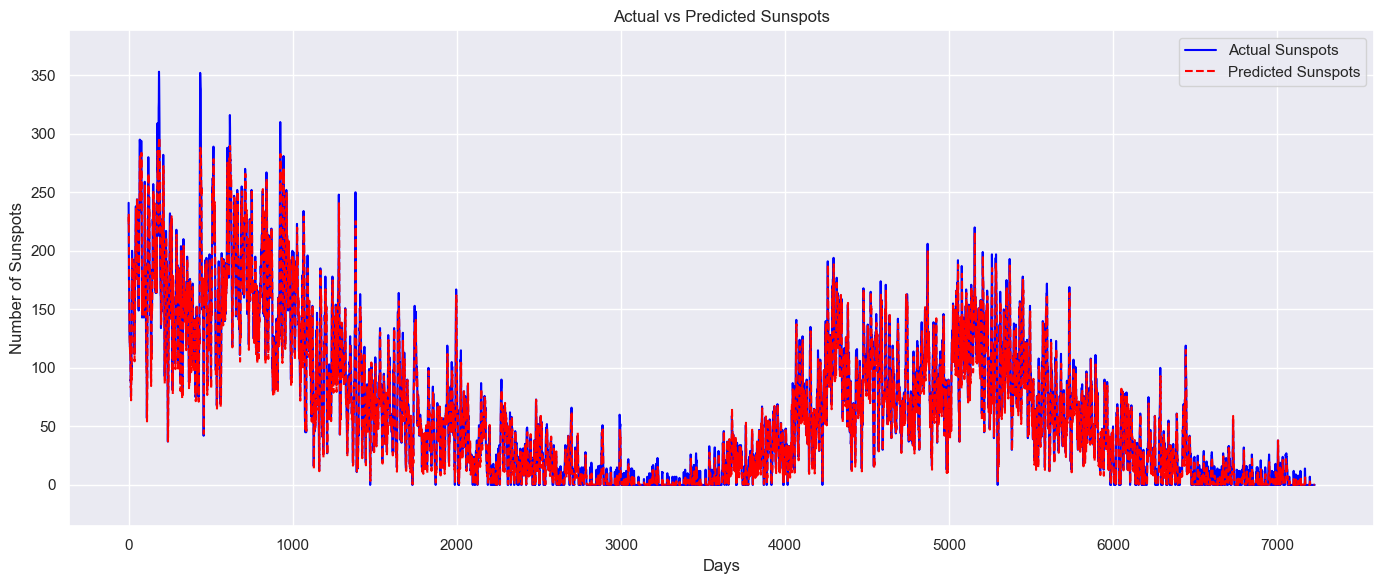

In [25]:
# Calculate minimum and maximum values across both actual and predicted values
y_min = min(np.min(y_test), np.min(predicted_sunspots))
y_max = max(np.max(y_test), np.max(predicted_sunspots))

# Set a bit of padding for better visualization
padding = 0.1 * (y_max - y_min)
y_min -= padding
y_max += padding

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 6))

# Plotting the actual values
plt.plot(y_test, label='Actual Sunspots', color='blue')

# Plotting the predicted values
plt.plot(predicted_sunspots, label='Predicted Sunspots', color='red', linestyle='--')

# Title and labels
plt.title('Actual vs Predicted Sunspots')
plt.ylabel('Number of Sunspots')
plt.xlabel('Days')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Setting the y-axis limits
plt.ylim(y_min, y_max)

# Display
plt.show()


## Comparing the Efficacy of GRU, BiLSTM, and LSTM deep learning models

In the code below we evaluate various model architectures through dynamic model building.  This allows for the tuning process to be flexible and scalable.  By abstracting the model creation process in this way, it becomes much easier to experiment. Comparing these recurrent layers allows us to identify the best configuration for our model.  

We evaluate LSTM, GRU, and BiLSTM types of recurrent layers. They each have their strengths and trade-offs.

LSTM (Long Short-Term Memory): a type of recurrent neural network (RNN) that can learn and remember over long sequences & is less susceptible to the vanishing gradient problem.

GRU (Gated Recurrent Unit): a simplified variant of LSTM which uses fewer parameters & thus can train faster & use less data to generalize.

BiLSTM (Bidirectional LSTM): involves using two LSTMs, one processing the sequence from start to end and another one from end to start. It can capture patterns from both directions in the sequence.


Trial 20 Complete [00h 02m 02s]
val_loss: 189.4658203125

Best val_loss So Far: 179.0335693359375
Total elapsed time: 01h 57m 49s
INFO:tensorflow:Oracle triggered exit
226/226 [==============================] - 2s 8ms/step


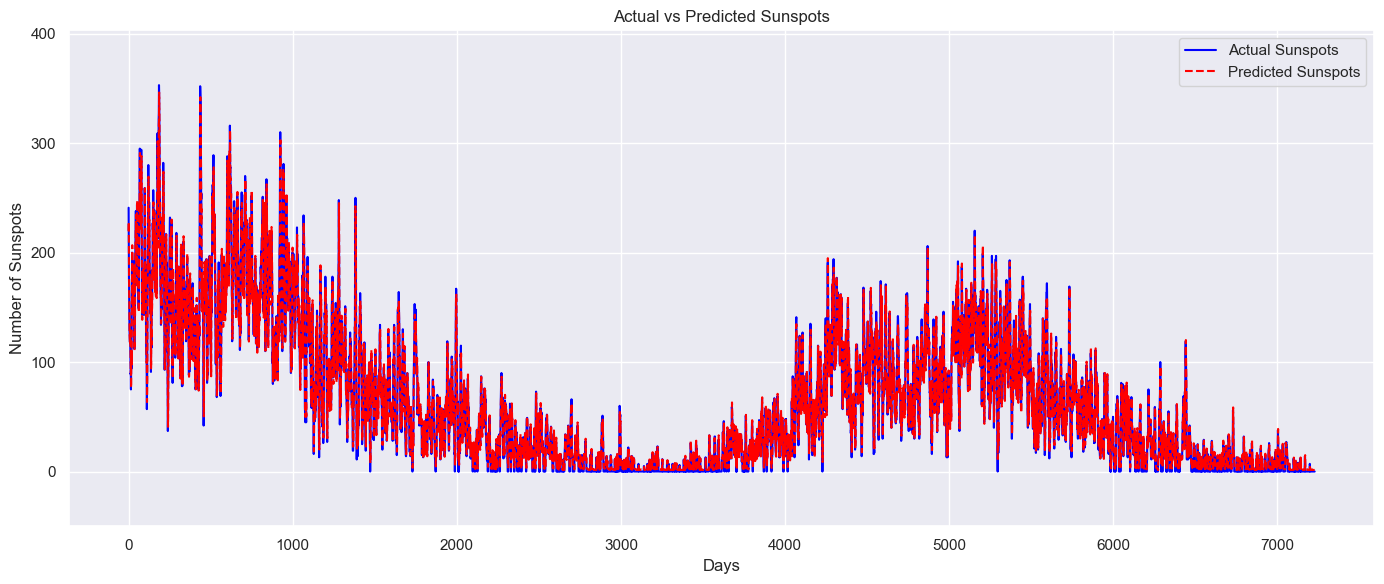

In [35]:

def build_model(hp):
    model = tf.keras.models.Sequential()
    
    # Choosing between LSTM, GRU, and BiLSTM
    choice_of_layer = hp.Choice('rnn_type', ['LSTM', 'GRU', 'BiLSTM'])
    
    if choice_of_layer == 'LSTM':
        model.add(tf.keras.layers.LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
            dropout=0.0,
            recurrent_dropout=0.0,
            input_shape=(None, 1)
        ))
    elif choice_of_layer == 'GRU':
        model.add(GRU(
            units=hp.Int('gru_units', min_value=32, max_value=256, step=32),
            dropout=0.0,
            recurrent_dropout=0.0,
            input_shape=(None, 1)
        ))
    elif choice_of_layer == 'BiLSTM':
        model.add(Bidirectional(LSTM(
            units=hp.Int('bilstm_units', min_value=32, max_value=256, step=32),
            dropout=0.0,
            recurrent_dropout=0.0
        ), input_shape=(None, 1)))
    
# Continuing with the dense layers
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
                        activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

# Setting up hyperparameter tuning using RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='sunspot_tuning',
    project_name='sunspot_rnn'
)

# Displaying the defined hyperparameter search space
tuner.search_space_summary()

# Setting up early stopping based on validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Starting the hyperparameter tuning process 
tuner.search(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stop], verbose=2)

# Getting the best model based on the tuning process
best_model = tuner.get_best_models(num_models=1)[0]

# Visualizing predictions vs. actual data
predicted_sunspots = best_model.predict(x_test)

plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Sunspots', color='blue')
plt.plot(predicted_sunspots, label='Predicted Sunspots', color='red', linestyle='--')
plt.title('Actual vs Predicted Sunspots')
plt.ylabel('Number of Sunspots')
plt.xlabel('Days')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(min(np.min(y_test), np.min(predicted_sunspots)) - 50, 
         max(np.max(y_test), np.max(predicted_sunspots)) + 50)
plt.show()


In [39]:
# display an overview of the hyperparameter search space.
tuner.search_space_summary()

# display a summary of the architecture of the best model identified by the tuner.
best_model.summary()

Search space summary
Default search space size: 9
rnn_type (Choice)
{'default': 'LSTM', 'conditions': [], 'values': ['LSTM', 'GRU', 'BiLSTM'], 'ordered': False}
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
bilstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
gru_units (